In [1]:
#'''
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
#'''
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time
from imutils import paths
import PIL.Image as Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time
from imutils import paths
import PIL.Image as Image
import json
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
from imutils import paths
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
path = "/content/drive/MyDrive"

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
detectron2 0.6 requires pycocotools>=2.0.2, but you have pycocotools 2.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-h8yz6jd7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-h8yz6jd7
  Resolved https://github.com/facebookresearch/detectron2.git to commit 94113be6e12db36b8c7601e13747587f19ec92fe
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstall

In [2]:
!nvidia-smi

Wed Jun 21 14:26:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import glob

image = sorted(glob.glob('/content/drive/MyDrive/*.jpg'))[:50]
label = sorted(glob.glob('/content/drive/MyDrive/*.json'))

print(len(image))
print(len(label))

50
50


In [ ]:
image

In [5]:
import pandas as pd
df = pd.read_csv("Recognition")
df

,file_name,width,height,x_min,x_max,y_min,y_max,class_name
0,1.jpg,653,322,56.794118,116.205882,109.529412,246.000000,L
1,1.jpg,653,322,123.852941,189.735294,111.882353,249.529412,U
2,1.jpg,653,322,188.558823,252.088235,116.000000,254.823529,V
3,1.jpg,653,322,258.558824,325.029412,121.882353,260.705882,T
4,1.jpg,653,322,322.676471,389.147059,117.764706,265.411765,A
...,...,...,...,...,...,...,...,...
323,50.jpg,255,182,66.376147,107.660550,63.133028,144.096330,P
324,50.jpg,255,182,103.990826,142.981651,70.931193,145.931193,0
325,50.jpg,255,182,139.311927,176.009174,77.123853,151.206422,0
326,50.jpg,255,182,170.963303,211.330275,79.646789,154.876147,K


# Model

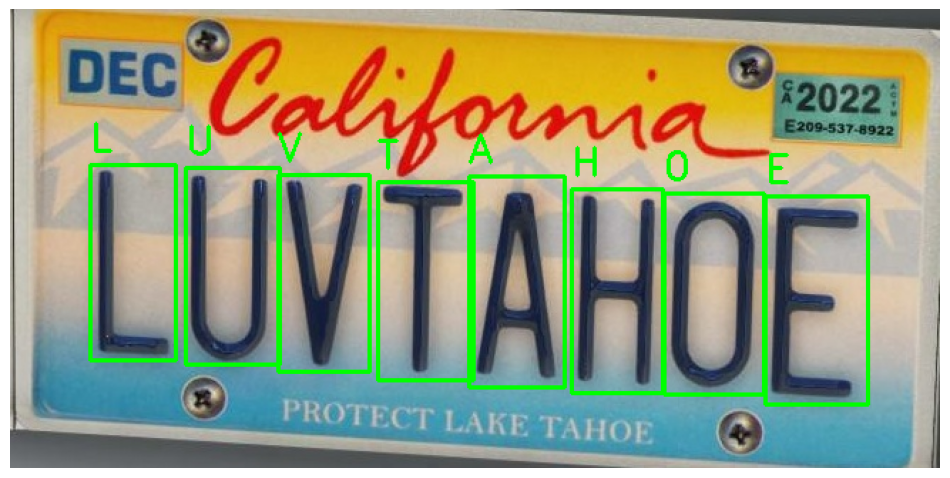

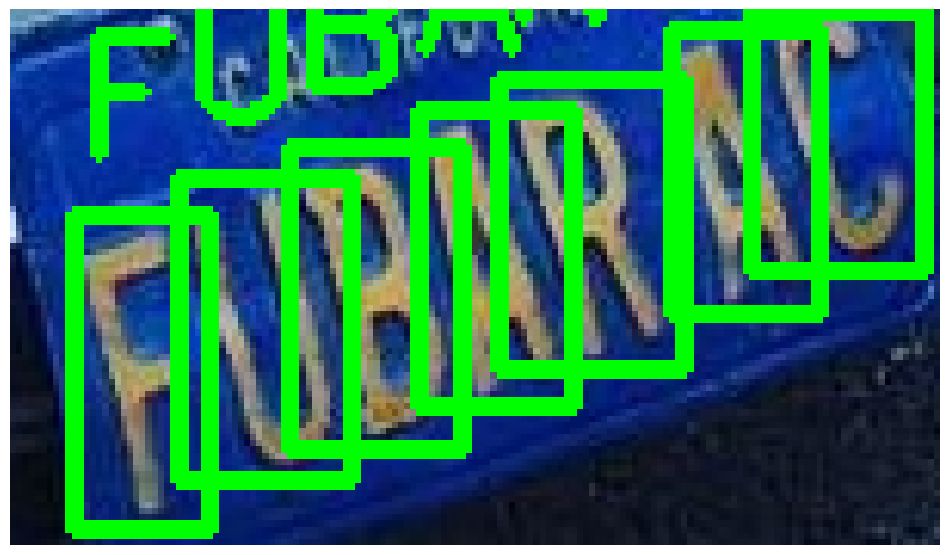

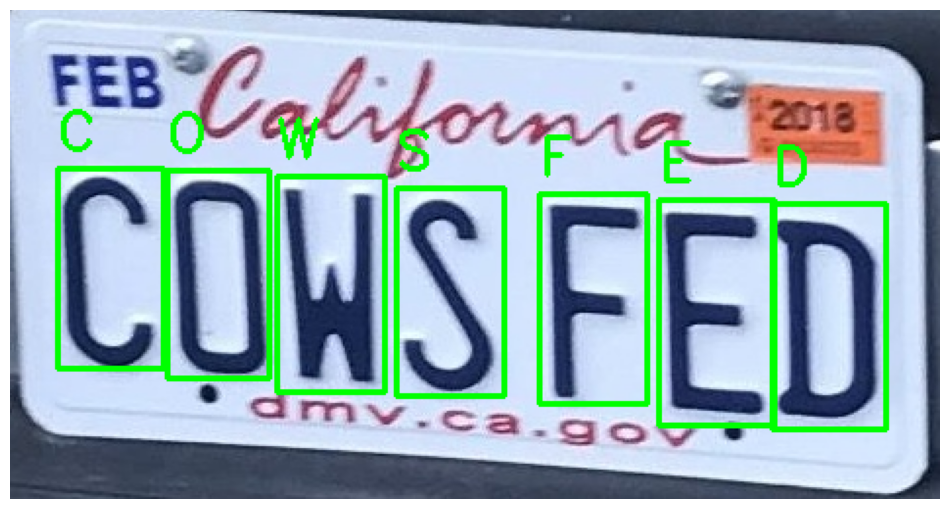

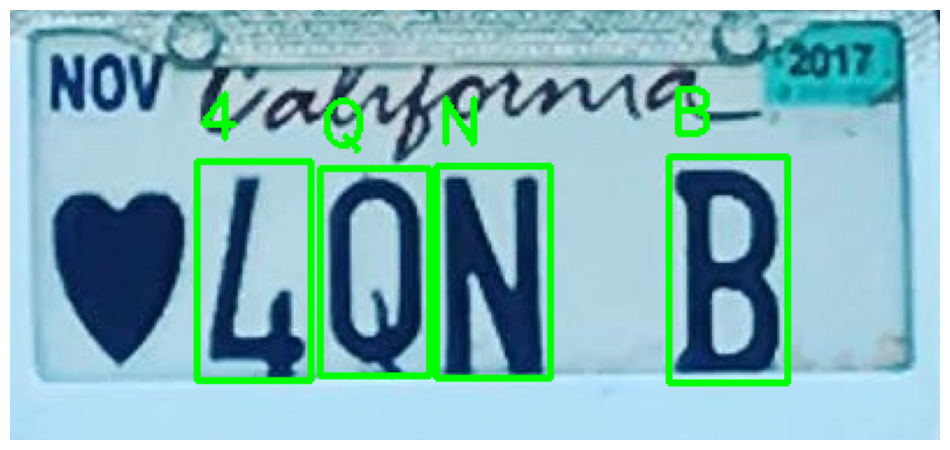

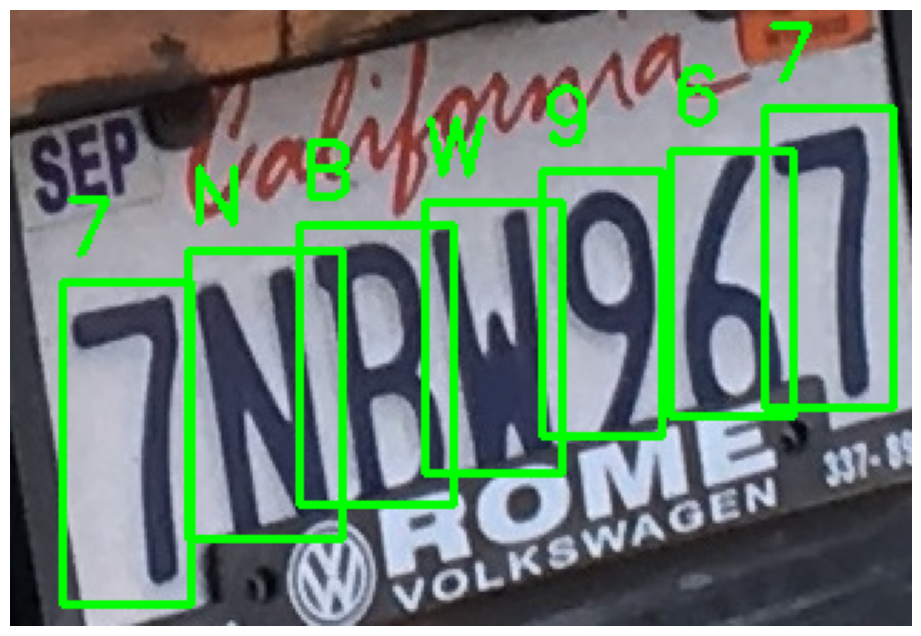

In [6]:
import os

image_path = "/content/drive/MyDrive"

# Group the objects by image
grouped_images = df.groupby("file_name")

# Keep track of the number of displayed images
displayed_images = 0

for image_name, group in grouped_images:
    if displayed_images >= 5:
        break

    # Construct the image path
    image_file = os.path.join(image_path, image_name)

    # Load the image
    image = cv2.imread(image_file)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Iterate over objects in the group and draw bounding boxes
    for _, row in group.iterrows():
        x_min = row["x_min"]
        x_max = row["x_max"]
        y_min = row["y_min"]
        y_max = row["y_max"]
        label = row["class_name"]  # Assuming the column name is "Label"

        # Draw the bounding box on the image
        image_rgb = cv2.rectangle(
            image_rgb,
            (int(x_min), int(y_min)),
            (int(x_max), int(y_max)),
            (0, 255, 0),
            2
        )

        # Add label text to the image
        cv2.putText(
            image_rgb,
            label,
            (int(x_min), int(y_min) - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (0, 255, 0),
            2
        )

    # Display the image with the bounding boxes
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    displayed_images += 1



In [7]:
train_df = df[:].copy()
# test_df = df[340:].copy()

In [8]:
print("Train Data Shape:", train_df.shape, "Number of samples:", len(train_df.file_name.unique()))
# print("Test Data Shape:", test_df.shape, "Number of samples:", len(test_df.Image.unique()))


Train Data Shape: (328, 8) Number of samples: 50


In [9]:
# Get the list of unique classes
classes = train_df['class_name'].unique().tolist()

# Print the list of classes
print("List of Classes:", classes)

List of Classes: ['L', 'U', 'V', 'T', 'A', 'H', '0', 'E', '7', '5', '2', 'J', 'X', 'N', '6', '4', 'G', 'Y', '9', '1', 'R', 'M', 'D', 'I', 'B', 'P', 'C', 'F', 'O', 'W', 'S', 'Q', '3', 'K', '8', 'Z']


In [10]:
def create_dataset_dicts(df, PATH):
    # Define the mapping between class names and category IDs
    class_to_category = {class_name: idx for idx, class_name in enumerate(classes)}

    dataset_dicts = []
    for image_id, img_name in enumerate(df.file_name.unique()):
        record = {}
        image_df = df[df.file_name == img_name]
        file_path = f'{PATH}/{img_name}'
        record["file_name"] = file_path
        record["image_id"] = image_id
        record["height"] = int(image_df.iloc[0].height)
        record["width"] = int(image_df.iloc[0].width)
        objs = []
        for _, row in image_df.iterrows():
            xmin = int(row.x_min)
            ymin = int(row.y_min)
            xmax = int(row.x_max)
            ymax = int(row.y_max)
            poly = [
                (xmin, ymin), (xmax, ymin),
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))
            class_name = row['class_name']
            category_id = class_to_category[class_name]
            obj = {
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [11]:
TRAIN_PATH = f'/content/drive/MyDrive/'


In [12]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Define your list of classes
classes = ['L', 'U', 'V', 'T', 'A', 'H', '0', 'E', '7', '5', '2', 'J', 'X', 'N', '6', '4', 'G', 'Y', '9', '1', 'R', 'M', 'D', 'I', 'B', 'P', 'C', 'F', 'O', 'W', 'S', 'Q', '3', 'K', '8', 'Z']

# Register the dataset
DatasetCatalog.register("imgs_train", lambda: create_dataset_dicts(train_df, TRAIN_PATH))
MetadataCatalog.get("imgs_train").set(thing_classes=classes)
statement_metadata = MetadataCatalog.get("imgs_train")


In [13]:
coco_eval_dir = "/content/drive/MyDrive/"

In [14]:
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs(coco_eval_dir, exist_ok=True)
            output_folder = coco_eval_dir
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [15]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [16]:
cfg.DATASETS.TRAIN = ("imgs_train",)
cfg.DATASETS.TEST = ()  # Remove the test set
cfg.DATALOADER.NUM_WORKERS = 2


In [17]:
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.021
cfg.SOLVER.WARMUP_ITERS = 5000
cfg.SOLVER.STEPS = (1500,)
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

In [18]:
cfg.SOLVER.MAX_ITER = 10
cfg.SOLVER.CHECKPOINT_PERIOD = 20
cfg.TEST.EVAL_PERIOD = 80

In [19]:
out_dir = "/content/drive/MyDrive/Output"

cfg.OUTPUT_DIR = out_dir

In [20]:
cfg.MODEL.DEVICE = "cuda"

In [21]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)

[06/21 14:26:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [22]:
trainer.train()

[06/21 14:26:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/21 14:27:15 d2.utils.events]:  eta: 1:01:06  iter: 19  total_loss: 4.759  loss_cls: 3.708  loss_box_reg: 0.9272  loss_rpn_cls: 0.1004  loss_rpn_loc: 0.0386    time: 1.8468  last_time: 2.1407  data_time: 0.0220  last_data_time: 0.0436   lr: 1.9405e-06  max_mem: 5908M
[06/21 14:27:57 d2.utils.events]:  eta: 1:00:45  iter: 39  total_loss: 4.662  loss_cls: 3.662  loss_box_reg: 0.8789  loss_rpn_cls: 0.08393  loss_rpn_loc: 0.03787    time: 1.8539  last_time: 1.7986  data_time: 0.0083  last_data_time: 0.0058   lr: 2.9305e-06  max_mem: 5908M
[06/21 14:28:36 d2.utils.events]:  eta: 1:00:44  iter: 59  total_loss: 4.572  loss_cls: 3.585  loss_box_reg: 0.8469  loss_rpn_cls: 0.09596  loss_rpn_loc: 0.03656    time: 1.8865  last_time: 2.0425  data_time: 0.0114  last_data_time: 0.0117   lr: 3.9205e-06  max_mem: 5908M
[06/21 14:29:17 d2.utils.events]:  eta: 1:00:36  iter: 79  total_loss: 4.418  loss_cls: 3.43  loss_box_reg: 0.8715  loss_rpn_cls: 0.06613  loss_rpn_loc: 0.04069    time: 1.9212  last_

In [ ]:
model_path = f"{out_dir}/model_final.pth"
cfg.MODEL.WEIGHTS = os.path.join(model_path)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.60
predictor = DefaultPredictor(cfg)

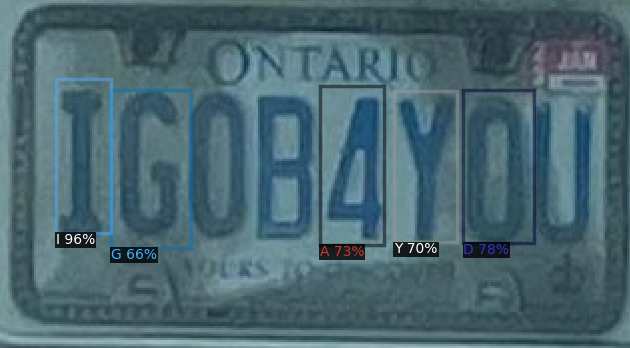

Prediction 1
Class: I
Score: 0.96000355
Bounding Box: [ 27.895554  39.74064   55.561646 116.546455]

Prediction 2
Class: D
Score: 0.78158164
Bounding Box: [231.74603  44.98595 266.75455 121.40582]

Prediction 3
Class: A
Score: 0.7308102
Bounding Box: [159.93462   42.890892 191.99915  122.362625]

Prediction 4
Class: Y
Score: 0.7017955
Bounding Box: [197.152    45.70963 228.55136 121.24392]

Prediction 5
Class: G
Score: 0.6597668
Bounding Box: [ 55.511513  44.86817   95.37954  123.99994 ]



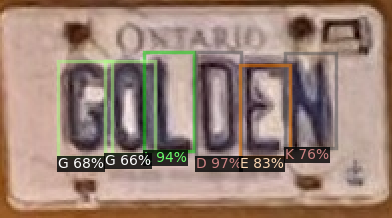

Prediction 1
Class: D
Score: 0.97088706
Bounding Box: [ 98.084564  25.825909 120.324814  78.41879 ]

Prediction 2
Class: L
Score: 0.9366023
Bounding Box: [71.87028  25.850887 97.0487   75.5665  ]

Prediction 3
Class: E
Score: 0.82787585
Bounding Box: [120.18755   32.389942 145.04767   78.52313 ]

Prediction 4
Class: K
Score: 0.7572561
Bounding Box: [142.36101   26.526863 167.98622   74.207214]

Prediction 5
Class: G
Score: 0.6794425
Bounding Box: [29.084574 30.672672 56.16417  78.39166 ]

Prediction 6
Class: G
Score: 0.66262746
Bounding Box: [52.71858  30.466898 77.60593  76.956436]



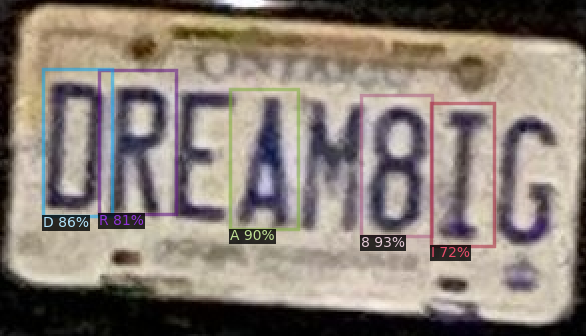

Prediction 1
Class: 8
Score: 0.93068045
Bounding Box: [180.55627   47.745457 215.91664  117.964455]

Prediction 2
Class: A
Score: 0.9001728
Bounding Box: [115.01226   44.663578 149.16786  114.74395 ]

Prediction 3
Class: D
Score: 0.8595263
Bounding Box: [ 21.616486  34.453564  55.860737 108.203476]

Prediction 4
Class: R
Score: 0.80684704
Bounding Box: [ 49.557404  34.773575  88.04672  106.79905 ]

Prediction 5
Class: I
Score: 0.7207067
Bounding Box: [215.53616  51.69923 247.0347  122.87935]



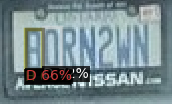

Prediction 1
Class: D
Score: 0.71583205
Bounding Box: [21.61316  13.473037 30.26864  33.286743]

Prediction 2
Class: D
Score: 0.6633431
Bounding Box: [12.976142 14.520131 21.447872 34.604965]

Prediction 3
Class: H
Score: 0.6067545
Bounding Box: [12.374319 14.734953 21.060232 34.845978]



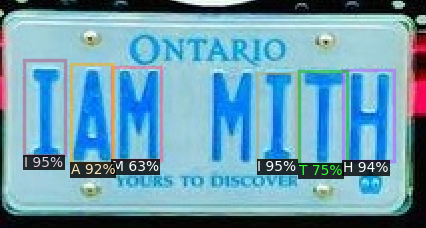

Prediction 1
Class: I
Score: 0.95217127
Bounding Box: [128.73468   36.320583 148.02458   80.12046 ]

Prediction 2
Class: I
Score: 0.945929
Bounding Box: [12.202169 29.782553 32.274487 77.75146 ]

Prediction 3
Class: H
Score: 0.93852216
Bounding Box: [171.63019   35.006054 196.7733    80.489456]

Prediction 4
Class: A
Score: 0.92316884
Bounding Box: [35.26891 32.13677 56.31534 81.7378 ]

Prediction 5
Class: T
Score: 0.7478145
Bounding Box: [149.62459   35.738033 173.31313   81.86796 ]

Prediction 6
Class: M
Score: 0.626023
Bounding Box: [56.048794 33.446884 80.42669  80.11974 ]



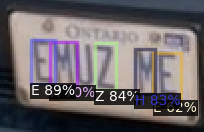

Prediction 1
Class: E
Score: 0.8851245
Bounding Box: [15.523193 19.975145 27.524628 41.991028]

Prediction 2
Class: Z
Score: 0.8393682
Bounding Box: [47.29493  21.718082 58.24249  44.787735]

Prediction 3
Class: H
Score: 0.8341773
Bounding Box: [67.39656  24.635143 77.303894 47.067554]

Prediction 4
Class: H
Score: 0.6966038
Bounding Box: [24.89348  20.83855  38.29139  42.941593]

Prediction 5
Class: E
Score: 0.61604
Bounding Box: [76.732834 26.65041  90.57724  50.361237]



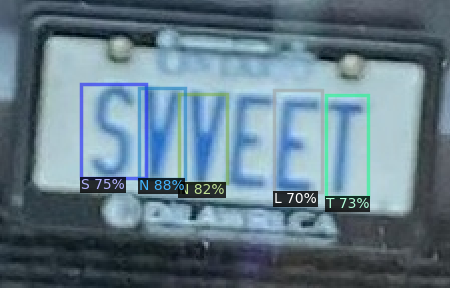

Prediction 1
Class: N
Score: 0.878541
Bounding Box: [69.34056  44.151176 92.339836 89.33237 ]

Prediction 2
Class: N
Score: 0.8162027
Bounding Box: [ 89.55763   46.800617 113.51524   91.400795]

Prediction 3
Class: S
Score: 0.7542081
Bounding Box: [40.553703 41.757984 72.964424 89.09807 ]

Prediction 4
Class: T
Score: 0.72650397
Bounding Box: [162.9472   47.66295 184.1654   98.59606]

Prediction 5
Class: L
Score: 0.704835
Bounding Box: [136.9667    44.806507 161.097     96.23745 ]



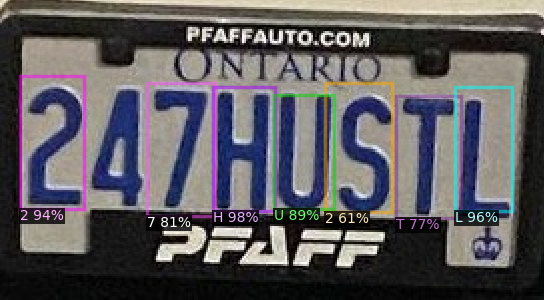

Prediction 1
Class: H
Score: 0.97753215
Bounding Box: [106.28958   43.659477 137.72849  105.47359 ]

Prediction 2
Class: L
Score: 0.96388674
Bounding Box: [227.33116  43.43899 256.04807 105.45713]

Prediction 3
Class: 2
Score: 0.9356628
Bounding Box: [  9.881434  37.919365  41.766785 104.66991 ]

Prediction 4
Class: U
Score: 0.89344305
Bounding Box: [136.89978   47.33241  166.8341   104.727325]

Prediction 5
Class: 7
Score: 0.8060189
Bounding Box: [ 73.589386  41.42727  107.34741  108.064545]

Prediction 6
Class: T
Score: 0.7654381
Bounding Box: [198.03699  47.8849  230.4144  108.92576]

Prediction 7
Class: 2
Score: 0.60989094
Bounding Box: [162.4183    41.739944 196.2119   106.08364 ]



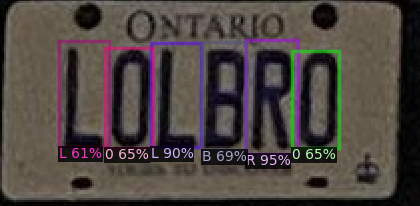

Prediction 1
Class: R
Score: 0.9450809
Bounding Box: [122.810196  19.908941 149.01074   76.78655 ]

Prediction 2
Class: L
Score: 0.90364
Bounding Box: [ 75.31721   21.354448 100.50292   73.49757 ]

Prediction 3
Class: B
Score: 0.69087845
Bounding Box: [100.84883   21.10095  122.358536  75.212   ]

Prediction 4
Class: 0
Score: 0.64673305
Bounding Box: [52.351364 24.073517 76.74407  73.888725]

Prediction 5
Class: 0
Score: 0.6458785
Bounding Box: [146.1009    25.599127 169.65013   73.85007 ]

Prediction 6
Class: L
Score: 0.60947615
Bounding Box: [29.585732 20.62105  54.453106 73.66014 ]



In [48]:
from google.colab.patches import cv2_imshow


# List of image paths
match command:
        image_paths = [
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        "/content/drive/MyDrive/[match command[i]].jpg",
        # Add more image paths as needed
    ]

# Loop through the image paths
for image_path in image_paths:
    # Load an image for prediction
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Make predictions on the image
    outputs = predictor(image_rgb)

    # Get the predicted instances (objects)
    instances = outputs["instances"]

    # Move tensors to CPU memory
    instances_pred_boxes = instances.pred_boxes.tensor.cpu().numpy()
    instances_scores = instances.scores.cpu().numpy()
    instances_classes = instances.pred_classes.cpu().numpy()

    # Visualize the predictions
    v = Visualizer(image_rgb, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2.0)  # Increase the scale value here

    # Draw the predicted bounding boxes and class names on the image
    vis_image = v.draw_instance_predictions(instances.to("cpu"))

    # Convert the image to BGR for proper display with OpenCV
    vis_image_bgr = cv2.cvtColor(vis_image.get_image(), cv2.COLOR_RGB2BGR)

    # Display the image with the predicted bounding boxes and class names
    cv2_imshow(vis_image_bgr)

    # Display the detailed predictions below the image
    for i, pred_class in enumerate(instances_classes):
        print("Prediction", i + 1)
        print("Class:", classes[pred_class])
        print("Score:", instances_scores[i])
        print("Bounding Box:", instances_pred_boxes[i])
        print()

    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [ ]:
SAVING JS  = "/content/drive/MyDrive/Marg bar Seyed Ali/ane model/"


In [53]:
from detectron2.data import build_detection_test_loader, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger

# Create an evaluator for the training dataset
evaluator = COCOEvaluator("imgs_train", cfg, False, output_dir=coco_eval_dir)

# Get the metadata of the training dataset
metadata = MetadataCatalog.get("imgs_train")

# Create a test data loader
data_loader = build_detection_test_loader(cfg, "imgs_train")

# Run inference on the training dataset
logger = setup_logger()
logger.info("Start inference on training dataset...")
results = inference_on_dataset(predictor.model, data_loader, evaluator)

# Access the overall accuracy from the inference results
overall_accuracy = results["bbox"]["AP"]

# Print the overall accuracy
print("Overall Accuracy:", overall_accuracy)


WARNING [06/21 16:35:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/21 16:35:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/21 16:35:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/21 16:35:43 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[06/21 16:35:43 d2.data.common]: Serialized dataset takes 0.03 MiB
[06/21 16:35:43 detectron2]: Start inference on training dataset...
[06/21 16:35:43 d2.evaluation.evaluator]: Start inference on 50 batches
[06/21 16:35:47 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.0119 s/iter. Inference: 0.2454 s/iter. Eval: 0.0004 s/iter. Total: 0.2576 s/iter. ETA=0:00:10
[06/21 16:35:52 d2.evaluation.evaluator]: Inferen